# Import

In [36]:
# import libraries
# python staples
import numpy as np
import pandas as pd
from pandas.core import datetools
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA

# scikitlearn
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
# xg boost
from xgboost import XGBClassifier

# Functions

In [192]:
# Mike's functions
def clean_data( mydata, drop_list, verbose ):
    # some data is pointless, get rid of id
    mydata = mydata.drop( drop_list, axis=1 )
    if "Embarked" in mydata:
        embark_df=pd.get_dummies(mydata.Embarked,prefix='embark')
        mydata=mydata.join(embark_df)
        mydata=mydata.drop('Embarked',axis=1)
    if "Cabin" in mydata:
        mydata.Cabin = mydata.Cabin.fillna('N')
        mydata.Cabin = mydata.Cabin.apply(lambda y: y[0])
        cabin_df = pd.get_dummies(mydata.Cabin,prefix='deck')
        if ('deck_T' not in cabin_df.columns):
            cabin_df = cabin_df.join(pd.Series(np.zeros(cabin_df.shape[0]),index=cabin_df.index,name='deck_T'))
        mydata = mydata.join(cabin_df)
        mydata=mydata.drop('Cabin',axis=1)
    # find isnan value
    if verbose == 1:
        print( 'before clean isnan check:\n', mydata.isna().any() )
    # turn male/female, embarked to a number
    mydata.loc[mydata.Sex == 'female','Sex' ] = 0
    mydata.loc[mydata.Sex == 'male','Sex' ] = 1
    # replace nan with average
    mydata.loc[mydata.Age.isnull(),'Age']  = np.mean( mydata.Age[~mydata.Age.isna()] )
    mydata.loc[mydata.Fare.isnull(),'Fare']  = np.mean( mydata.Fare[~mydata.Fare.isna()] )
    #normalize
    mydata.Age = ( mydata.Age - mydata.Age.mean() ) / mydata.Age.std()
    mydata.Fare = ( mydata.Fare - mydata.Fare.mean() ) / mydata.Fare.std()
    if verbose:
        print('after clean isnan check:\n', mydata.isna().any() )
        print( 'Cleaned data:', mydata.iloc[0] )
    return mydata

def sklearn_fit( fitmodel, x_train, y_train, x_cv, y_cv, verbose ):
    fitmodel.fit(x_train, y_train)
    y_pred = fitmodel.predict(x_cv)
    #accuracy = get_accuracy( y_cv, prediction )
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_cv, predictions)
    model = {'prediction': predictions, 'accuracy': accuracy }
    return model


In [172]:
# Jeff's functions
def massageData(df):
    df.Cabin=df.Cabin.fillna('N')
    df['CabinDeck']=df.Cabin.apply(lambda y: y[0])
    df['HasAge'] = df.Age.notnull().apply(lambda y: 1 if y else 0)
    df['HasCabin'] = df.Cabin.apply(lambda y: 0 if y=='N' else 1)
    df['parchMale0']=df.apply(lambda row: 1 if (row['Sex']=='male' and row['Parch']==0) else 0,axis=1)
    df['parchMale']=df.apply(lambda row: 1 if (row['Sex']=='male' and row['Parch']>0) else 0, axis=1)
    df['sibspMale0']=df.apply(lambda row: 1 if (row['Sex']=='male' and row['SibSp']==0) else 0, axis=1)
    df['sibspMale']=df.apply(lambda row: 1 if (row['Sex']=='male' and row['SibSp']>0) else 0, axis=1)
    df['parchFemale0']=df.apply(lambda row: 1 if (row['Sex']=='female' and row['Parch']==0) else 0,axis=1)
    df['parchFemale']=df.apply(lambda row: 1 if (row['Sex']=='female' and row['Parch']>0) else 0, axis=1)
    df['sibspFemale0']=df.apply(lambda row: 1 if (row['Sex']=='female' and row['SibSp']==0) else 0, axis=1)
    df['sibspFemale']=df.apply(lambda row: 1 if (row['Sex']=='female' and row['SibSp']>0) else 0, axis=1)
    df['pcssMale0']=df.apply(lambda row: 1 if (row['Sex']=='male' and (row['Parch']==0 and row['SibSp']==0)) else 0,axis=1)
    df['pcssMale']=df.apply(lambda row: 1 if (row['Sex']=='male' and (row['Parch']>0 or row['SibSp']>0)) else 0, axis=1)
    df['pcssFemale0']=df.apply(lambda row: 1 if (row['Sex']=='female' and (row['SibSp']==0 and row['Parch']==0)) else 0, axis=1)
    df['pcssFemale']=df.apply(lambda row: 1 if (row['Sex']=='female' and (row['SibSp']>0 or row['Parch']>0)) else 0, axis=1)
    #df.Age = df.Age.fillna(0)
    #df.Fare=df.Fare.fillna(df.Fare.median())
    df.loc[df.Age.isnull(),'Age']  = np.median( df.Age[~df.Age.isna()] )
    df.loc[df.Fare.isnull(),'Fare']  = np.median( df.Fare[~df.Fare.isna()] )
    #normalize
    df.Age = ( df.Age - df.Age.mean() ) / df.Age.std()
    df.Fare = ( df.Fare - df.Fare.mean() ) / df.Fare.std()
    return df
def getDeckDummies(df):
    deckX = df['HasCabin']
    return deckX
def getDeckDummiesFull(df):
    deckX = pd.get_dummies(df.CabinDeck,prefix='deck')
    if ('deck_T' not in deckX.columns):
        deckX = deckX.join(pd.Series(np.zeros(deckX.shape[0]),index=deckX.index,name='deck_T'))
def getEmbarkDummies(df):
    embarkX = pd.get_dummies(df.Embarked,prefix='embark')
    return embarkX
def getPclassDummies(df):
    pclassX = pd.get_dummies(df.Pclass,prefix='class')
    return pclassX
def getSexX(df):
    return df[['pcssMale0','pcssMale','pcssFemale0','pcssFemale']]
def getAgeX(df):
    return df[['Age','HasAge']]
def getFullModelX(df):
    deckX = getDeckDummies(df)
    embarkX = getEmbarkDummies(df)
    pclassX = getPclassDummies(df)
    sexX = getSexX(df)
    ageX = getAgeX(df)
    fareX = df.Fare
    return pd.concat([deckX,embarkX,pclassX,sexX,ageX,fareX],axis=1)

# Mike's analysis

## Grab data and get a preview

In [205]:
# grab the data and put it in a pandas dataframe
df_train_all = pd.read_csv('train.csv',index_col=0)
df_test_all = pd.read_csv('test.csv',index_col=0)
# print some info
print('Original train data set:\n\n', df_train_all.iloc[0])
print('Original test data set:\n\n', df_test_all.iloc[0])
num_features = len( df_train_all.columns ) - 1
print('\n features:', num_features )

Original train data set:

 Survived                          0
Pclass                            3
Name        Braund, Mr. Owen Harris
Sex                            male
Age                              22
SibSp                             1
Parch                             0
Ticket                    A/5 21171
Fare                           7.25
Cabin                           NaN
Embarked                          S
Name: 1, dtype: object
Original test data set:

 Pclass                     3
Name        Kelly, Mr. James
Sex                     male
Age                     34.5
SibSp                      0
Parch                      0
Ticket                330911
Fare                  7.8292
Cabin                    NaN
Embarked                   Q
Name: 892, dtype: object

 features: 10


## Clean data

In [206]:
# clean data
#drop_list = ['PassengerId','Name','Ticket', 'Cabin']
drop_list = ['Name','Ticket']#, 'Cabin']
# break the y data to train, validation set
train_frac = 0.66;
num_tot = len( df_train_all.index)

# clean it
y_train_cv = df_train_all.Survived
df_data = clean_data( df_train_all, drop_list, 0)
# separate into training/test sets
x_train_cv = df_data.drop( 'Survived', axis=1 )
x_test = clean_data( df_test_all, drop_list, 0)
# print some info
num_features_test = len( x_test.columns )
num_features_train = len( x_train_cv.columns )
print( 'Data set:\n', x_train_cv.iloc[0])
print( 'Data set:\n', x_test.iloc[0])

Data set:
 Pclass      3.000000
Sex         1.000000
Age        -0.592148
SibSp       1.000000
Parch       0.000000
Fare       -0.502163
embark_C    0.000000
embark_Q    0.000000
embark_S    1.000000
deck_A      0.000000
deck_B      0.000000
deck_C      0.000000
deck_D      0.000000
deck_E      0.000000
deck_F      0.000000
deck_G      0.000000
deck_N      1.000000
deck_T      0.000000
Name: 1, dtype: float64
Data set:
 Pclass      3.000000
Sex         1.000000
Age         0.334592
SibSp       0.000000
Parch       0.000000
Fare       -0.497811
embark_C    0.000000
embark_Q    1.000000
embark_S    0.000000
deck_A      0.000000
deck_B      0.000000
deck_C      0.000000
deck_D      0.000000
deck_E      0.000000
deck_F      0.000000
deck_G      0.000000
deck_N      1.000000
deck_T      0.000000
Name: 892, dtype: float64


## Plotting


### Correlation plot

<Figure size 432x288 with 0 Axes>

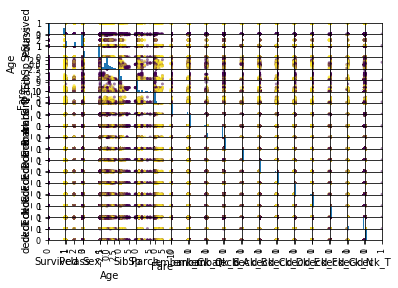

In [207]:
plt.figure()
pd.plotting.scatter_matrix(df_data,c=df_data.Survived)
plt.show()

### PCA

Text(0.5,1,'PCA')

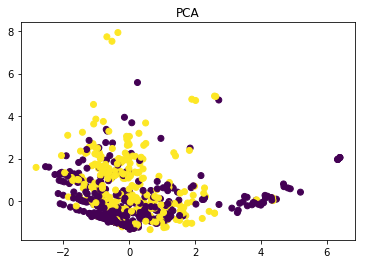

In [182]:
# Principal component analysis
# 2d
pca2 = PCA(n_components=2)
pca2.fit(x_train_cv)
x_transform2 = pca2.transform(x_train_cv)
plt.scatter( x_transform2[:,0], x_transform2[:,1], c = y_train_cv )
plt.title('PCA')

## Fitting

### Stat models logistic

See what parameters are relevant

In [208]:
# Logistical fit using sm.Logit
logistic = sm.Logit(y_train_cv, x_train_cv)
# fit the model
result = logistic.fit()
print( result.summary2() )


         Current function value: inf
         Iterations: 35


/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/statsmodels/discrete/discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

## Fit over sklearn and other models

In [209]:
# fit them all
verbose = 0
# sci-kit learn logistic regression
logistic = LogisticRegression()
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
# SVM: linear kernal
linear_svc = SVC(kernel='linear')
# SVM: gaussian kernal
gaussian_svc = SVC(kernel='rbf')
# random forest
randfor = RandomForestClassifier(max_depth=2, random_state=0)
# knn 
n_neighbors = 12
knn = KNeighborsClassifier(n_neighbors)
# boosting forest
boost_for = XGBClassifier()
# build a list
list_o_fits = [logistic, lda, linear_svc, 
               gaussian_svc, randfor, knn,
              boost_for]

In [210]:
# try this over many random sets of the data
num_trials = 10
seed = 314159
test_size = 0.33
accuracy_mat = np.zeros( (num_trials, len(list_o_fits) ))
for i in range(num_trials):
    # separate into training sets
    x_train, x_cv, y_train, y_cv = train_test_split(
        x_train_cv, y_train_cv, test_size=test_size, random_state=seed)
    seed += 1
    # fit
    fit_results = [ sklearn_fit(a_fit, x_train, y_train, 
                                x_cv, y_cv, verbose) 
                   for a_fit in list_o_fits]
    accuracy_mat[i,:] = np.array( [a_fit["accuracy"] for a_fit in fit_results] )
# average for the best
mean_accuracy = accuracy_mat.mean(axis=0)
bestmodelid=mean_accuracy.argmax()
std_accuracy = accuracy_mat.std(axis=0)
best_model = {'accuracy': mean_accuracy[bestmodelid],
              'std':std_accuracy[bestmodelid],
              'list_ind': bestmodelid, 
              'class_name': list_o_fits[bestmodelid].__class__ };
print( best_model )

/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variabl

{'list_ind': 6, 'class_name': <class 'xgboost.sklearn.XGBClassifier'>, 'accuracy': 0.82101694915254231, 'std': 0.019103732615058117}


# Jeff's Analysis

### Define data structures

In [96]:
def getFullModelX(df):
    deckX = getDeckDummies(df)
    embarkX = getEmbarkDummies(df)
    pclassX = getPclassDummies(df)
    sexX = getSexX(df)
    ageX = getAgeX(df)
    fareX = df.Fare
    return pd.concat([deckX,embarkX,pclassX,sexX,ageX,fareX],axis=1)

### Read and organize data

In [135]:
trainDF=massageData(pd.read_csv('train.csv',index_col=0))
trainX=getFullModelX(trainDF)
trainY=trainDF.Survived
testDF=massageData(pd.read_csv('test.csv',index_col=0))
testX=getFullModelX(testDF)
jeffX = trainX
jeffY = trainY

In [136]:
print(testX.iloc[0])

HasCabin       0.000000
embark_C       0.000000
embark_Q       1.000000
embark_S       0.000000
class_1        0.000000
class_2        0.000000
class_3        1.000000
pcssMale0      1.000000
pcssMale       0.000000
pcssFemale0    0.000000
pcssFemale     0.000000
Age            0.385769
HasAge         1.000000
Fare          -0.496818
Name: 892, dtype: float64


### Test accuracy with logistic regression

In [137]:
logreg = LogisticRegression(C=100,max_iter=100)
cv = ShuffleSplit(n_splits=100, test_size=1/3, random_state=590145)
cvs=cross_val_score(logreg,trainX,trainY,cv=cv)
print("Accuracy: ",cvs.mean(),"+/-",cvs.std())

Accuracy:  0.803501683502 +/- 0.0168250475533


### Make predictions for test data

In [143]:
model = logreg.fit(trainX,trainY)
#model.predict(testX)

In [139]:
# try this over many random sets of the data
num_trials = 5
seed = 12341643
test_size = 0.33
accuracy_mat = np.zeros( (num_trials, len(list_o_fits) ))
for i in range(num_trials):
    # separate into training sets
    x_train, x_cv, y_train, y_cv = train_test_split(
        jeffX, jeffY, test_size=test_size, random_state=seed)
    seed += 1
    # fit
    fit_results = [ sklearn_fit(a_fit, x_train, y_train, 
                                x_cv, y_cv, verbose) 
                   for a_fit in list_o_fits]
    accuracy_mat[i,:] = np.array( [a_fit["accuracy"] for a_fit in fit_results] );


/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [140]:
# average for the best
mean_accuracy = accuracy_mat.mean(axis=0)
bestmodelid=mean_accuracy.argmax()
std_accuracy = accuracy_mat.std(axis=0)
best_model = {'accuracy': mean_accuracy[bestmodelid],
              'std':std_accuracy[bestmodelid],
              'list_ind': bestmodelid, 
              'class_name': list_o_fits[bestmodelid].__class__ };
print( best_model )

{'list_ind': 6, 'class_name': <class 'xgboost.sklearn.XGBClassifier'>, 'accuracy': 0.80949152542372871, 'std': 0.019812392130444011}


## Individual parameter significance tests

### Embarkment: Significant, but likely confounding variable with pClass, Fare, etc

In [56]:
embarkX = trainX[['embark_C','embark_Q','embark_S']]

In [57]:
model = sm.Logit(trainY,embarkX)

In [58]:
model=model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.650800
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.02269
Time:                        12:56:31   Log-Likelihood:                -579.86
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.420e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
embark_C       0.2151      0.155      1.386      0.166      -0.089       0.519
embark_Q      -0.4490      0.234     -1.921      0.055      -0.907       0.009
embark_S      -0.6769      0.083     -8.119      0.000      -0.840      -0.513
==============================================================================
"""

In [59]:
data = trainX.join(trainY)
nC = sum(data.embark_C)
nQ = sum(data.embark_Q)
nS = sum(data.embark_S)
surviveCpercent = sum(data[data['embark_C']==1].Survived)/sum(data.embark_C)
surviveQpercent = sum(data[data['embark_Q']==1].Survived)/sum(data.embark_Q)
surviveSpercent = sum(data[data['embark_S']==1].Survived)/sum(data.embark_S)

In [60]:
#Survival percentages (by eye) with total 
#passengers number from that embarkment point
print("C: ",surviveCpercent," ",nC)
print("Q: ",surviveQpercent," ",nQ)
print("S: ",surviveSpercent," ",nS)

C:  0.553571428571   168
Q:  0.38961038961   77
S:  0.336956521739   644


### Embarkment is correlated with Pclass (which explains significance)

In [166]:
trainX[['class_1','class_2','class_3','embark_S','embark_Q','embark_C','Fare']].corr()

,class_1,class_2,class_3,embark_S,embark_Q,embark_C,Fare
class_1,1.000000,-0.288585,-0.626738,-0.170379,-0.155342,0.296423,0.591711
class_2,-0.288585,1.000000,-0.565210,0.192061,-0.127301,-0.125416,-0.118557
class_3,-0.626738,-0.565210,1.000000,-0.009511,0.237449,-0.153329,-0.413333
embark_S,-0.170379,0.192061,-0.009511,1.000000,-0.496624,-0.778359,-0.166603
embark_Q,-0.155342,-0.127301,0.237449,-0.496624,1.000000,-0.148258,-0.117216
embark_C,0.296423,-0.125416,-0.153329,-0.778359,-0.148258,1.000000,0.269335
Fare,0.591711,-0.118557,-0.413333,-0.166603,-0.117216,0.269335,1.000000


### Sex: very significant

In [146]:
sexX = pd.get_dummies(trainDF.Sex)
model = sm.Logit(trainY,sexX).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                  0.2266
Time:                        13:36:16   Log-Likelihood:                -458.90
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 2.020e-60
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
female         1.0566      0.129      8.191      0.000       0.804       1.309
male          -1.4571      0.106    -13.701      0.000      -1.666      -1.249
==============================================================================
"""

### Pclass: very significant for 1st and 3rd class

In [142]:
pclassX = trainX[['class_1','class_2','class_3']]

In [144]:
model = sm.Logit(trainY,pclassX)
model = model.fit(method='cg')
model.summary()

Optimization terminated successfully.
         Current function value: 0.607805
         Iterations: 5
         Function evaluations: 15
         Gradient evaluations: 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.08726
Time:                        13:35:52   Log-Likelihood:                -541.55
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 3.274e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
class_1        0.5306      0.141      3.766      0.000       0.254       0.807
class_2       -0.1088      0.148     -0.737      0.461      -0.398       0.181
class_3       -1.1398      0.105    -10.822      0.000      -1.346      -0.933
==============================================================================
"""

### Fare: correlated with pclass, so also very significant

In [64]:
fareX = sm.add_constant(trainX.Fare)
model = sm.Logit(trainY,fareX)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.627143
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.05822
Time:                        12:56:32   Log-Likelihood:                -558.78
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 9.427e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9413      0.095     -9.895      0.000      -1.128      -0.755
Fare           0.0152      0.002      6.809      0.000       0.011       0.020
==============================================================================
"""

### Age & HasAge: Significant

In [65]:
ageX = trainX[['Age','HasAge']]
model = sm.Logit(trainY,sm.add_constant(ageX))
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.659134
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.01018
Time:                        12:56:33   Log-Likelihood:                -587.29
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                  0.002385
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8771      0.165     -5.315      0.000      -1.200      -0.554
Age           -0.0110      0.005     -2.057      0.040      -0.021      -0.001
HasAge         0.8203      0.240      3.425      0.001       0.351       1.290
==============================================================================
"""

### Deck

In [170]:
deckX = pd.get_dummies(trainDF['CabinDeck'])
model = sm.Logit(trainY,deckX)
model = model.fit(method='ncg')
model.summary()

Optimization terminated successfully.
         Current function value: 0.610797
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 14
         Hessian evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.08277
Time:                        14:39:32   Log-Likelihood:                -544.22
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 9.882e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.1335      0.518     -0.258      0.796      -1.148       0.881
B              1.0704      0.335      3.200      0.001       0.415       1.726
C              0.3773      0.265      1.424      0.155      -0.142       0.897
D              1.1394      0.406      2.805      0.005       0.343       1.936
E              1.0986      0.408      2.691      0.007       0.298       1.899
F              0.4700      0.570      0.824      0.410      -0.647       1.587
G                   0      1.000          0      1.000      -1.960       1.960
N             -0.8480      0.083    -10.184      0.000      -1.011      -0.685
T             -5.1954     13.508     -0.385      0.701     -31.670      21.279
==============================================================================
"""

In [171]:
deckX.join(trainX.Fare).corr()

,A,B,C,D,E,F,G,N,T,Fare
A,1.000000,-0.030880,-0.034846,-0.025663,-0.025256,-0.015923,-0.008787,-0.240136,-0.004386,0.019549
B,-0.030880,1.000000,-0.062841,-0.046280,-0.045547,-0.028715,-0.015847,-0.433053,-0.007910,0.386297
C,-0.034846,-0.062841,1.000000,-0.052225,-0.051398,-0.032403,-0.017883,-0.488683,-0.008926,0.364318
D,-0.025663,-0.046280,-0.052225,1.000000,-0.037852,-0.023864,-0.013170,-0.359896,-0.006574,0.098878
E,-0.025256,-0.045547,-0.051398,-0.037852,1.000000,-0.023486,-0.012961,-0.354194,-0.006470,0.053717
F,-0.015923,-0.028715,-0.032403,-0.023864,-0.023486,1.000000,-0.008171,-0.223299,-0.004079,-0.033093
G,-0.008787,-0.015847,-0.017883,-0.013170,-0.012961,-0.008171,1.000000,-0.123234,-0.002251,-0.025180
N,-0.240136,-0.433053,-0.488683,-0.359896,-0.354194,-0.223299,-0.123234,1.000000,-0.061513,-0.482075
T,-0.004386,-0.007910,-0.008926,-0.006574,-0.006470,-0.004079,-0.002251,-0.061513,1.000000,0.002224
Fare,0.019549,0.386297,0.364318,0.098878,0.053717,-0.033093,-0.025180,-0.482075,0.002224,1.000000


### Alternate model: Distinguish between has a cabin or not

In [151]:
hasCabinX = trainX[['deck_N']]
model = sm.Logit(trainY,hasCabinX).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.629608
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.05452
Time:                        13:38:06   Log-Likelihood:                -560.98
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deck_N        -0.8480      0.083    -10.184      0.000      -1.011      -0.685
==============================================================================
"""

### Nonzero siblings/spouses

In [153]:
sibsp0X = trainDF.SibSp.apply(lambda y: 0 if y>0 else 1)
sibsp0X.name = 'SibSp0'
sibsp0X = pd.concat([sibsp0X,trainDF.SibSp.apply(lambda y: 1 if y>0 else 0)],axis=1)
model = sm.Logit(trainY,sibsp0X)
model = model.fit(method='newton')
model.summary()

Optimization terminated successfully.
         Current function value: 0.659268
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                0.009977
Time:                        13:41:49   Log-Likelihood:                -587.41
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 0.0005801
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SibSp0        -0.6393      0.085     -7.496      0.000      -0.807      -0.472
SibSp         -0.1345      0.119     -1.129      0.259      -0.368       0.099
==============================================================================
"""

### Nonzero parents or children

In [152]:
parch0X = trainDF.Parch.apply(lambda y: 0 if y>0 else 1)
parch0X.name = 'Parch0'
parch0X = pd.concat([parch0X,trainDF.Parch.apply(lambda y: 1 if y>0 else 0)],axis=1)
#parch0X = PCA(parch0X,method='eig').factors
model = sm.Logit(trainY,parch0X)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.655251
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      889
Method:                           MLE   Df Model:                            1
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                 0.01601
Time:                        13:41:39   Log-Likelihood:                -583.83
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.308e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Parch0        -0.6470      0.081     -8.002      0.000      -0.806      -0.489
Parch          0.0470      0.137      0.343      0.732      -0.222       0.316
==============================================================================
"""

### Test alternate model: Distinguish effect of nonzero parents/children/spouses/siblings between male/female

In [76]:
pcssX = df[['pcssMale0','pcssMale','pcssFemale0','pcssFemale']]
model = sm.Logit(trainY,pcssX).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.508372
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Sat, 24 Mar 2018   Pseudo R-squ.:                  0.2366
Time:                        12:56:35   Log-Likelihood:                -452.96
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.468e-60
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
pcssMale0      -1.6904      0.136    -12.426      0.000      -1.957      -1.424
pcssMale       -0.9891      0.175     -5.665      0.000      -1.331      -0.647
pcssFemale0     1.2993      0.217      5.984      0.000       0.874       1.725
pcssFemale      0.9089      0.161      5.639      0.000       0.593       1.225
===============================================================================
"""

# Final solution: XG-BOOST no special data cleaning

In [211]:
boost_for = XGBClassifier()
boost_for.fit(x_train_cv,y_train_cv)
sol=boost_for.predict(x_test)

In [212]:
x_test.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [199]:
f = open('titanic_predictions.csv','w')
f.write('PassengerId,Survived\n')
for i,p in zip(sol.index,sol):
    f.write(str(i)+','+str(p)+'\n')
f.close()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [203]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,embark_C,embark_Q,embark_S,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_N,deck_T
0,3,1,0.334592,0,0,-0.497811,0,1,0,0,0,0,0,0,0,0,1,0.0
1,3,0,1.323944,1,0,-0.512660,0,0,1,0,0,0,0,0,0,0,1,0.0
2,2,1,2.511166,0,0,-0.464532,0,1,0,0,0,0,0,0,0,0,1,0.0
3,3,1,-0.259019,0,0,-0.482888,0,0,1,0,0,0,0,0,0,0,1,0.0
4,3,0,-0.654760,1,1,-0.417971,0,0,1,0,0,0,0,0,0,0,1,0.0
5,3,1,-1.287945,0,0,-0.472814,0,0,1,0,0,0,0,0,0,0,1,0.0
6,3,0,-0.021575,0,0,-0.501392,0,1,0,0,0,0,0,0,0,0,1,0.0
7,2,1,-0.338168,1,1,-0.118681,0,0,1,0,0,0,0,0,0,0,1,0.0
8,3,0,-0.971353,0,0,-0.508555,1,0,0,0,0,0,0,0,0,0,1,0.0
9,3,1,-0.733908,2,0,-0.205535,0,0,1,0,0,0,0,0,0,0,1,0.0


In [204]:
x_train

,Pclass,Sex,Age,SibSp,Parch,Fare,embark_C,embark_Q,embark_S,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_N,deck_T
420,3,1,0.000000,0,0,-0.489167,1,0,0,0,0,0,0,0,0,0,1,0
453,1,1,1.484453,1,0,1.145020,1,0,0,0,0,1,0,0,0,0,0,0
20,2,1,0.407697,0,0,-0.124850,0,0,1,0,0,0,0,0,0,0,1,0
857,1,1,1.638275,0,0,-0.113782,0,0,1,0,0,0,0,1,0,0,0,0
636,3,1,0.176964,0,0,-0.488580,0,0,1,0,0,0,0,0,0,0,1,0
823,3,0,-0.207592,0,1,-0.397018,0,0,1,0,0,0,0,1,0,0,0,0
403,3,1,-0.130681,1,0,-0.329102,0,0,1,0,0,0,0,0,0,0,1,0
292,2,1,0.484608,0,0,-0.388969,1,0,0,0,0,0,1,0,0,0,0,0
245,1,1,1.099897,2,0,1.163047,0,1,0,0,0,1,0,0,0,0,0,0
443,2,0,-0.130681,0,0,-0.386454,0,0,1,0,0,0,0,0,0,0,1,0
